# Read in the data

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

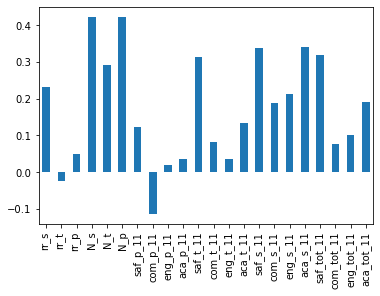

In [13]:
combined.corr()["sat_score"][survey_fields].plot.bar()

## Response Rates and Total Responses

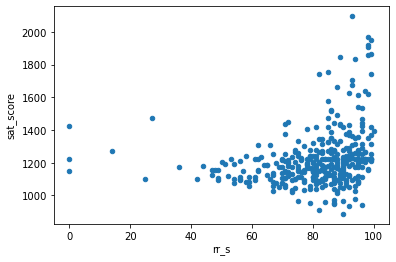

In [14]:
combined.plot.scatter(x='rr_s', y='sat_score')

plt.show()

The correlation in the response rates was with Students `rr_s` was weak, but was far stronger than the rates for Teachers and Parents. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

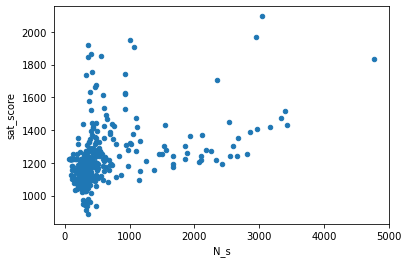

In [15]:
combined.plot.scatter(x='N_s', y='sat_score')

plt.show()

Again, while the number of students `N_s` showed a high r-value, plotting it out showed that the majority of the schools stuck in the bottom left of the scatter plot. I did note there was an interesting pattern forming that looked like a positive correlation, though.

The numbers of students, parents and teachers correlate highly with Total enrollment, so it makes sense that they would correlate highly with SAT scores as well.

## Exploring Saftey and Academic Standards

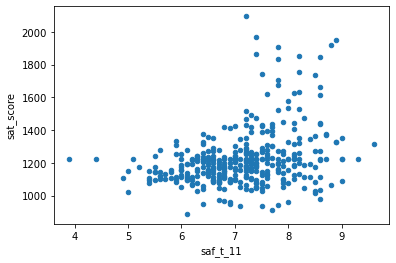

In [18]:
combined.plot.scatter(x='saf_t_11', y='sat_score')

plt.show()

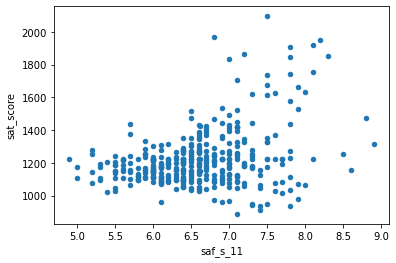

In [19]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

plt.show()

There appears to be a correlation between SAT scores and safety, although it isn't a strong one. There are only some schools with both high SAT scores and safety scores. Similarly, there are a few schools with low safety scores and low SAT scores. Aside from a couple of exceptions, no school with a safety score lower than 7 has an average SAT score higher than 1600 or so.

The overall patterns between the teachers and the students scatterplots appear the same, too. 

# Safety by Borough
As NYC is a larger metropolitan city, our next step is to break out our data by borough to see how safety and SAT scores vary between them:

In [20]:
boroughs = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boroughs)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


Matching my perceptions, the highest rated boroughs for safety were Manhattan and Queens, but I wasn't expecting Brooklyn to beat out the Bronx for the lowest average safety score.

# Racial Inequality and SAT scores

<AxesSubplot:>

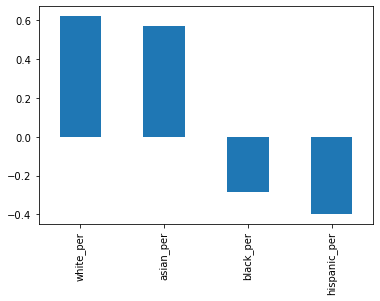

In [21]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

No suprising news here: schools with a higher percentage of black and hispanic students correlate negatively to SAT scores. This isn't due to the SAT tests themselves, but that black and hispanic families suffer disproportionately because of income inequality, and with the wealth gap at the home is accompanied by the wealth gap between schools.

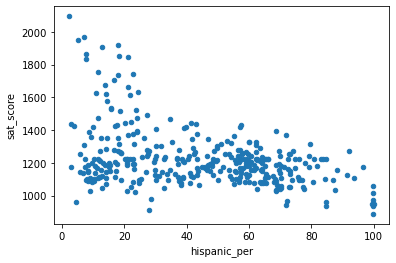

In [22]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

plt.show()

In [24]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [26]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


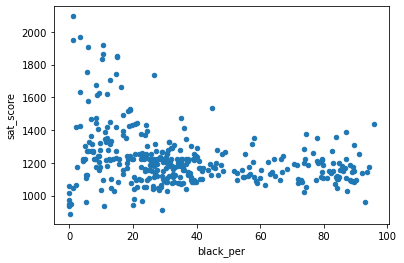

In [23]:
combined.plot.scatter(x='black_per', y='sat_score')

plt.show()

In [27]:
print(combined[(combined["black_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                  STUYVESANT HIGH SCHOOL
151           BRONX HIGH SCHOOL OF SCIENCE
302            TOWNSEND HARRIS HIGH SCHOOL
356    STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In checking both situations where the black and hispanic percentage was less that 10% and where the SAT scores were over 1800, the schools that showed in each result tended to be prestigious puplic magnet schools in the NYC school district system. Many of them require their own assesment exams to get in, which would make sense that students who got into those schools would be prepared to do well on the SATs.

## Gender differences in SAT scores

<AxesSubplot:>

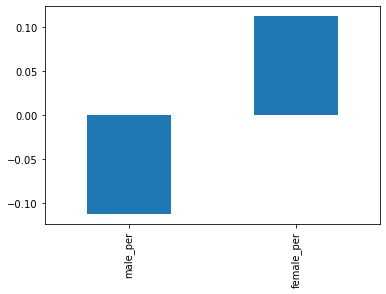

In [28]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

These r-values aren't particularly strong, but we will plot these out and see if any patterns show:

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

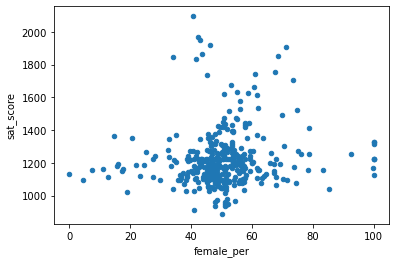

In [29]:
combined.plot.scatter("female_per", "sat_score")

<AxesSubplot:xlabel='male_per', ylabel='sat_score'>

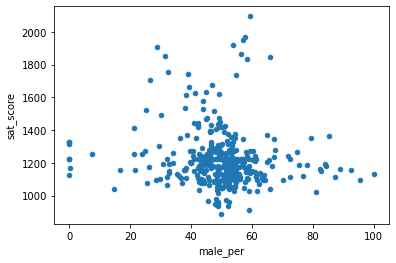

In [30]:
combined.plot.scatter("male_per", "sat_score")

Based on the scatterplots there doesn't seem to be any real correlation between sat_score and gender. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [31]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [36]:
print(combined[(combined["male_per"] > 20) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards, but also overlap with ones from the men's scatterplot.

## AP Exam Scores vs SAT Scores

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

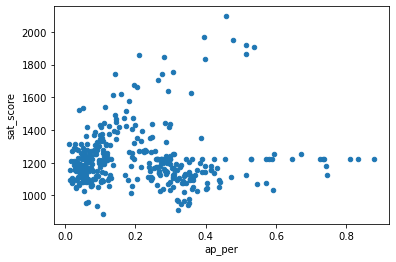

In [37]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.